In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [7]:
image_directory = '/content/drive/MyDrive/CMB_images/images/'
mask_directory = '/content/drive/MyDrive/CMB_images/masks/'

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import AffineTransform, warp
from skimage import io, img_as_ubyte
import random
import os
from scipy.ndimage import rotate

import albumentations as A
images_to_generate=100

In [ ]:
# img_augmented_path="/content/drive/MyDrive/Final_Dataset-2-4-24-deleted/aug_img/" # path to store aumented images
# msk_augmented_path="/content/drive/MyDrive/Final_Dataset-2-4-24-deleted/aug_msk/" # path to store aumented images

In [ ]:
# images=[] # to store paths of images from folder
# masks=[]
# for im in os.listdir(image_directory):  # read image name from folder and append its path into "images" array
#     images.append(os.path.join(image_directory,im))

# for msk in os.listdir(mask_directory):  # read image name from folder and append its path into "images" array
#     masks.append(os.path.join(mask_directory,msk))

In [ ]:
# import albumentations as A
# import cv2

# aug= A.Compose([
#     A.RandomCrop(width=256, height=256),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
# ])

In [ ]:
# aug = A.Compose([
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.Transpose(p=1),
#     A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#     A.GridDistortion(p=1)
#     ]
# )

# #random.seed(42)

# i=1   # variable to iterate till images_to_generate


In [ ]:
# while i<=images_to_generate:
#     number = random.randint(0, len(images)-1)  #PIck a number to select an image & mask
#     image = images[number]
#     mask = masks[number]
#     print(image, mask)
#     #image=random.choice(images) #Randomly select an image name
#     original_image = io.imread(image)
#     original_mask = io.imread(mask)

#     augmented = aug(image=original_image, mask=original_mask)
#     transformed_image = augmented['image']
#     transformed_mask = augmented['mask']


#     new_image_path= "%s/augmented_image_%s.jpg" %(img_augmented_path, i)
#     new_mask_path = "%s/augmented_mask_%s.jpg" %(msk_augmented_path, i)
#     io.imsave(new_image_path, transformed_image)
#     io.imsave(new_mask_path, transformed_mask)
#     i =i+1


In [5]:
!pip install keras-unet-collection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
# image_directory = '/content/drive/MyDrive/Final_Dataset-2-4-24-deleted/images/'
# mask_directory = '/content/drive/MyDrive/Final_Dataset-2-4-24-deleted/masks/'

In [9]:

SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'jpg'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 0)
        image = cv2.applyColorMap(image, cv2.COLORMAP_JET)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(mask_directory+image_name, 0)
        # image = cv2.applyColorMap(image, cv2.COLORMAP_JET)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [10]:
#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

In [11]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

# X_train_quick_test, X_test_quick_test, y_train_quick_test, y_test_quick_test = train_test_split(X_train, y_train, test_size = 0.9, random_state = 0)


In [12]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8
#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
#from focal_loss import BinaryFocalLoss


In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

In [13]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model


In [14]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [15]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=1,
                    validation_data=(X_test, y_test),
                    shuffle=False)

model.save('mitochondria_test.hdf5')

############################################################
#Evaluate the model


	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")



13/13 [==============================] - 32s 907ms/step - loss: 0.2338 - accuracy: 0.9785 - val_loss: 0.0630 - val_accuracy: 0.9892


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 3s 3s/step - loss: 0.0630 - accuracy: 0.9892
Accuracy =  98.91802072525024 %


In [16]:
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def sensitivity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())

    true_positives = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())

    true_negatives = K.sum(K.round(K.clip((1-y_true_c) * (1-y_pred_c), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true_c, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [17]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss=dice_coef_loss, \
                      metrics=[iou, dice_coef, sensitivity, 'binary_accuracy'])


In [18]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/50
13/13 [==============================] - 12s 225ms/step - loss: -0.0105 - iou: 0.0054 - dice_coef: 0.0108 - sensitivity: 1.0000 - binary_accuracy: 0.9890 - val_loss: -0.0157 - val_iou: 0.0091 - val_dice_coef: 0.0180 - val_sensitivity: 1.0000 - val_binary_accuracy: 0.9892
Epoch 2/50
13/13 [==============================] - 2s 177ms/step - loss: -0.0203 - iou: 0.0105 - dice_coef: 0.0207 - sensitivity: 1.0000 - binary_accuracy: 0.9890 - val_loss: -0.0248 - val_iou: 0.0145 - val_dice_coef: 0.0286 - val_sensitivity: 1.0000 - val_binary_accuracy: 0.9892
Epoch 3/50
13/13 [==============================] - 2s 178ms/step - loss: -0.0294 - iou: 0.0152 - dice_coef: 0.0298 - sensitivity: 1.0000 - binary_accuracy: 0.9890 - val_loss: -0.0319 - val_iou: 0.0188 - val_dice_coef: 0.0369 - val_sensitivity: 1.0000 - val_binary_accuracy: 0.9892
Epoch 4/50
13/13 [==============================] - 2s 178ms/step - loss: -0.0353 - iou: 0.0182 - dice_coef: 0.0357 - sensitivity: 1.0000 - binary_accura

In [19]:
from keras.optimizers import Adam
from keras_unet_collection import models, losses
from datetime import datetime

batch_size = 8
###############################################################################
#Model 1: Unet with ImageNet trained VGG16 backbone
help(models.unet_2d)
axis=3
model_Unet = models.unet_2d((256,256,3), filter_num=[64, 128, 256, 512, 1024],
                           n_labels=1,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU',
                           output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False,
                           backbone='VGG19', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='unet')


model_Unet.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3),
              metrics=[iou, dice_coef, sensitivity, 'binary_accuracy'])

print(model_Unet.summary())

start1 = datetime.now()

Unet_history = model_Unet.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    shuffle=False,
                    epochs=50)

stop1 = datetime.now()

Help on function unet_2d in module keras_unet_collection._model_unet_2d:

unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    U-net with an optional ImageNet-trained bakcbone.
    
    unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
            activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
            backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    
    ----------
    Ronneberger, O., Fischer, P. and Brox, T., 2015, October. U-net: Convolutional networks for biomedical image segmentation. 
    In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.
    
    Input
    ----------
        input_s

/usr/local/lib/python3.10/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG19 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


80134624/80134624 [==============================] - 1s 0us/step


Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 VGG19_backbone (Functional  [(None, 256, 256, 64),       2002438   ['input_2[0][0]']             
 )                            (None, 128, 128, 128),      4                                       
                              (None, 64, 64, 256),                                                
                              (None, 32, 32, 512),                                                
                              (None, 16, 16, 512)]                                                
                                                                                         

1/1 [==============================] - 0s 20ms/step


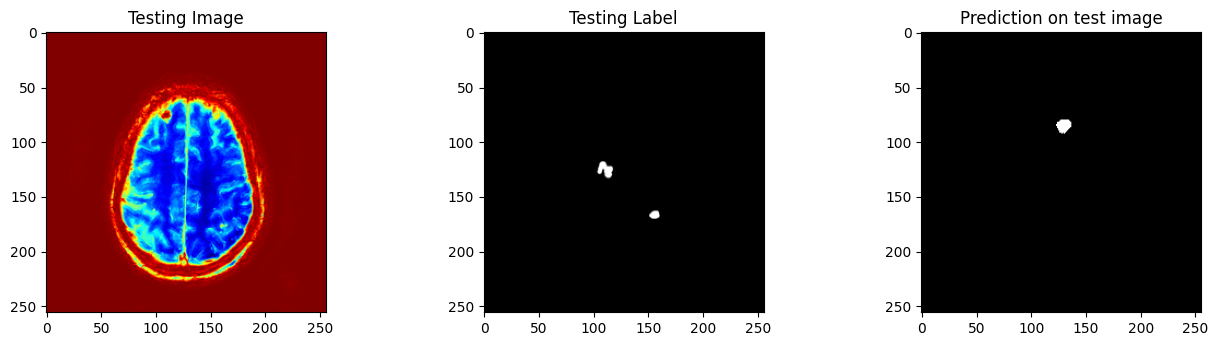

In [23]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

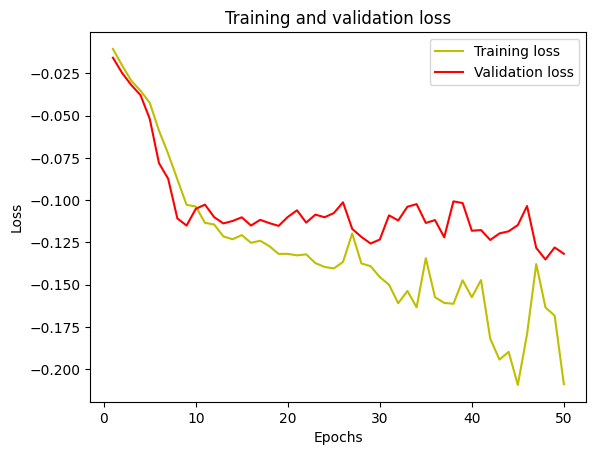

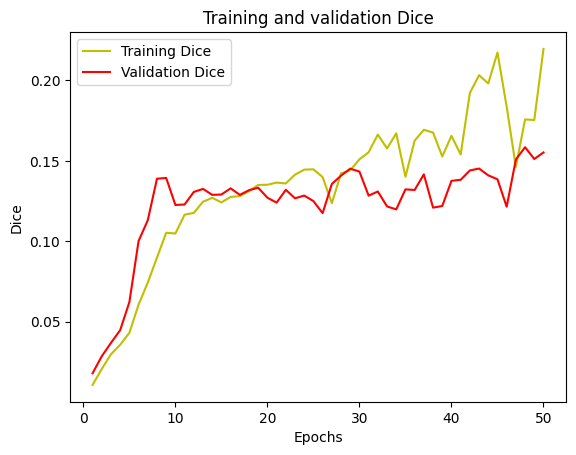

In [24]:
import pandas as pd
unet_history_df = pd.DataFrame(history.history)

with open('unet_history_df.csv', mode='w') as f:
    unet_history_df.to_csv(f)


# history = Unet_history


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()


1/1 [==============================] - 0s 21ms/step


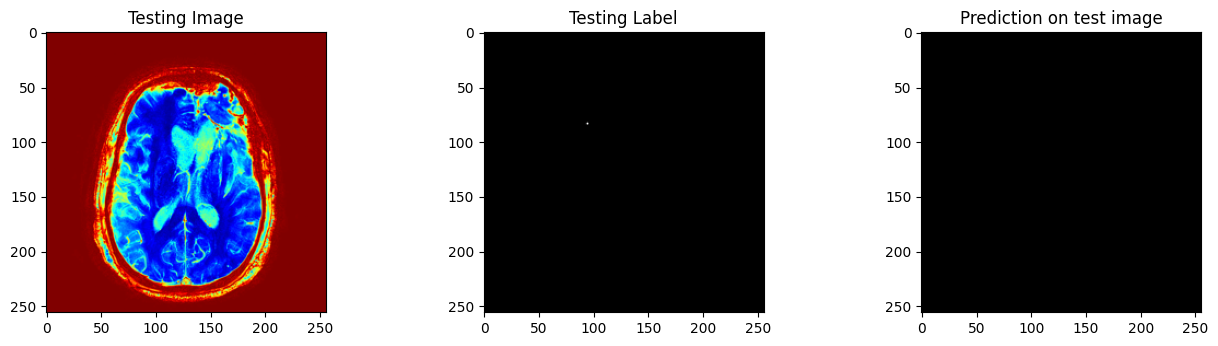

Mean IoU = 0.49999237
1/1 [==============================] - 0s 19ms/step
0.49330902
1/1 [==============================] - 0s 19ms/step
0.49990845
1/1 [==============================] - 0s 22ms/step
0.49943542
1/1 [==============================] - 0s 21ms/step
0.4982376
1/1 [==============================] - 0s 20ms/step
0.49518585
1/1 [==============================] - 0s 20ms/step
0.49734497
1/1 [==============================] - 0s 26ms/step
0.49919128
1/1 [==============================] - 0s 21ms/step
0.4984131
1/1 [==============================] - 0s 22ms/step
0.49999237
1/1 [==============================] - 0s 20ms/step
1.0
1/1 [==============================] - 0s 28ms/step
0.53527576
1/1 [==============================] - 0s 19ms/step
0.49884796
1/1 [==============================] - 0s 21ms/step
0.49830627
1/1 [==============================] - 0s 26ms/step
0.6462149
1/1 [==============================] - 0s 22ms/step
0.49999237
1/1 [==============================] - 0s 2

In [32]:
# model = model_Unet
import random
test_img_number = random.randint(0, X_test.shape[0]-1)  #Test with 119

test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU and average

import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)



df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)


In [26]:
# Unet Plus
help(models.unet_plus_2d)

model_Unet_plus = models.unet_plus_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024],
                           n_labels=num_labels,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU',
                           output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False,
                           backbone='VGG16', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='unet_plus')


model_Unet_plus.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3),
              metrics=[iou, dice_coef, sensitivity, 'binary_accuracy'])

print(model_Unet_plus.summary())

start2 = datetime.now()

Unet_plus_history = model_Unet_plus.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    shuffle=False,
                    epochs=50)

stop2 = datetime.now()
#Execution time of the model
execution_time_Unet_plus = stop2-start2
print("UNet plus execution time is: ", execution_time_Unet_plus)



Help on function unet_plus_2d in module keras_unet_collection._model_unet_plus_2d:

unet_plus_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, deep_supervision=False, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='xnet')
    U-net++ with an optional ImageNet-trained backbone.
    
    unet_plus_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
                 activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, deep_supervision=False, 
                 backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='xnet')
    
    ----------
    Zhou, Z., Siddiquee, M.M.R., Tajbakhsh, N. and Liang, J., 2018. Unet++: A nested u-net architecture 
    for medical image segmentation. In Deep Learning in Medical Image Analysis and Multimodal Learning 
    for C

/usr/local/lib/python3.10/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


58889256/58889256 [==============================] - 1s 0us/step


Model: "unet_plus_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 VGG16_backbone (Functional  [(None, 256, 256, 64),    14714688  
 )                            (None, 128, 128, 128),             
                              (None, 64, 64, 256),               
                              (None, 32, 32, 512),               
                              (None, 16, 16, 512)]               
                                                                 
 unet_plus_up0_from3_decode  (None, 32, 32, 512)       2359808   
 _trans_conv (Conv2DTranspo                                      
 se)                                                             
                                                                 
 unet_plus_up0_from3_decode  (None, 32, 32, 512)   

1/1 [==============================] - 0s 19ms/step


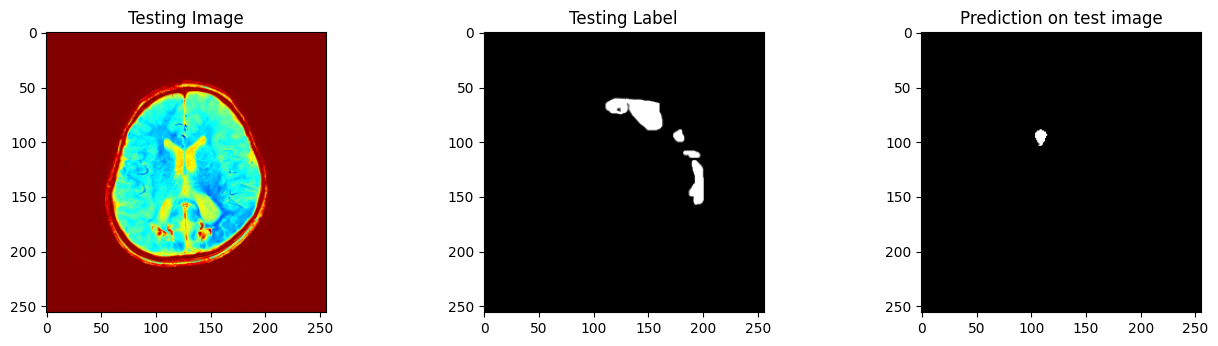

Mean IoU = 0.4902649
1/1 [==============================] - 0s 30ms/step
0.49520588
1/1 [==============================] - 0s 20ms/step
0.49990845
1/1 [==============================] - 0s 19ms/step
0.49943542
1/1 [==============================] - 0s 36ms/step
0.49743652
1/1 [==============================] - 0s 36ms/step
0.49409485
1/1 [==============================] - 0s 29ms/step
0.49734497
1/1 [==============================] - 0s 29ms/step
0.49919128
1/1 [==============================] - 0s 28ms/step
0.4984131
1/1 [==============================] - 0s 30ms/step
0.49999237
1/1 [==============================] - 0s 27ms/step
0.49930573
1/1 [==============================] - 0s 29ms/step
0.5636712
1/1 [==============================] - 0s 31ms/step
0.49819183
1/1 [==============================] - 0s 38ms/step
0.51638514
1/1 [==============================] - 0s 28ms/step
0.6767082
1/1 [==============================] - 0s 27ms/step
0.49999237
1/1 [==============================] 

In [33]:
model = model_Unet_plus
import random
test_img_number = random.randint(0, X_test.shape[0]-1)  #Test with 119

test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU and average

import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.3).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)



df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)


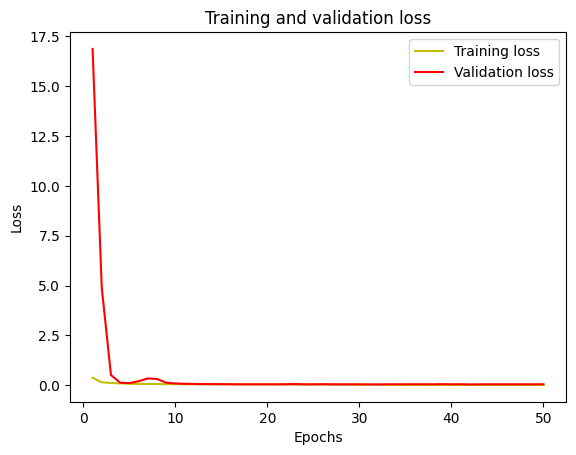

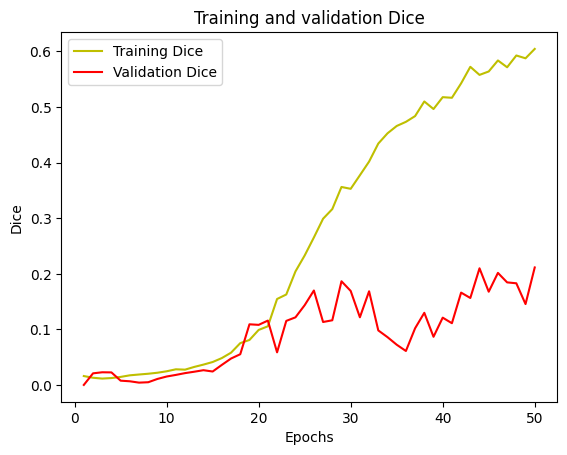

In [29]:
import pandas as pd
unet_history_df = pd.DataFrame(Unet_plus_history.history)

with open('unet_history_df.csv', mode='w') as f:
    unet_history_df.to_csv(f)


history = Unet_history


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [30]:
help(models.att_unet_2d)

model_att_unet = models.att_unet_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024],
                           n_labels=num_labels,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU',
                           atten_activation='ReLU', attention='add',
                           output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False,
                           backbone='VGG16', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='attunet')


model_att_unet.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3),
              metrics=['accuracy', losses.dice_coef])

print(model_att_unet.summary())

Help on function att_unet_2d in module keras_unet_collection._model_att_unet_2d:

att_unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', atten_activation='ReLU', attention='add', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='attunet')
    Attention U-net with an optional ImageNet backbone
    
    att_unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', 
                atten_activation='ReLU', attention='add', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
                backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='att-unet')
                
    ----------
    Oktay, O., Schlemper, J., Folgoc, L.L., Lee, M., Heinrich, M., Misawa, K., Mori, K., McDonagh, S., Hammerla, N.Y., Kainz, B. 
    and Glocker, B., 2018. Attention u-

Model: "attunet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 VGG16_backbone (Functional  [(None, 256, 256, 64),       1471468   ['input_4[0][0]']             
 )                            (None, 128, 128, 128),      8                                       
                              (None, 64, 64, 256),                                                
                              (None, 32, 32, 512),                                                
                              (None, 16, 16, 512)]                                                
                                                                                      

In [31]:
start3 = datetime.now()

att_unet_history = model_att_unet.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    shuffle=False,
                    epochs=50)

stop3 = datetime.now()
#Execution time of the model
execution_time_att_Unet = stop3-start3
print("Attention UNet execution time is: ", execution_time_att_Unet)

Epoch 1/50
26/26 [==============================] - 24s 509ms/step - loss: 0.2707 - accuracy: 0.9439 - dice_coef: 0.0171 - val_loss: 1.9762 - val_accuracy: 0.9892 - val_dice_coef: 3.4554e-05
Epoch 2/50
26/26 [==============================] - 12s 455ms/step - loss: 0.1109 - accuracy: 0.9890 - dice_coef: 0.0149 - val_loss: 0.2828 - val_accuracy: 0.9892 - val_dice_coef: 0.0114
Epoch 3/50
26/26 [==============================] - 12s 456ms/step - loss: 0.0802 - accuracy: 0.9890 - dice_coef: 0.0164 - val_loss: 0.0604 - val_accuracy: 0.9892 - val_dice_coef: 0.0181
Epoch 4/50
26/26 [==============================] - 12s 448ms/step - loss: 0.0641 - accuracy: 0.9890 - dice_coef: 0.0195 - val_loss: 0.0523 - val_accuracy: 0.9892 - val_dice_coef: 0.0137
Epoch 5/50
26/26 [==============================] - 11s 439ms/step - loss: 0.0562 - accuracy: 0.9890 - dice_coef: 0.0225 - val_loss: 0.0748 - val_accuracy: 0.9892 - val_dice_coef: 0.0094
Epoch 6/50
26/26 [==============================] - 11s 438ms

1/1 [==============================] - 0s 442ms/step


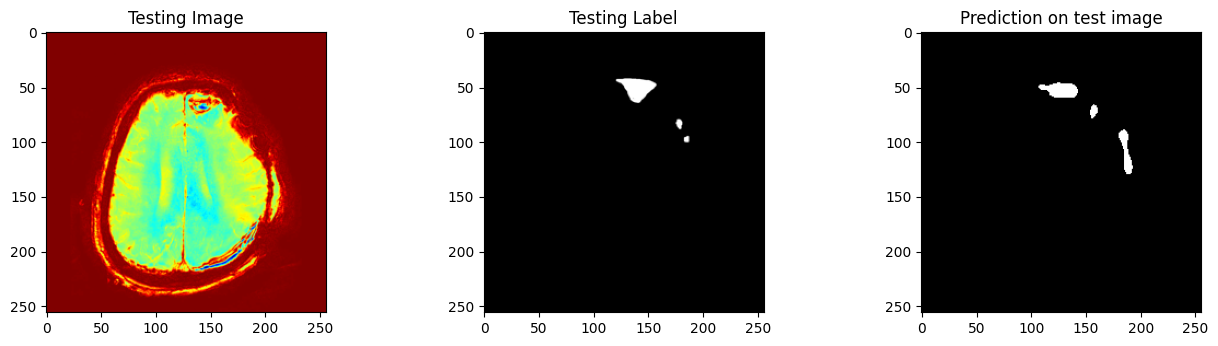

Mean IoU = 0.57361764
1/1 [==============================] - 0s 20ms/step
0.49492645
1/1 [==============================] - 0s 24ms/step
0.4979248
1/1 [==============================] - 0s 24ms/step
0.49939728
1/1 [==============================] - 0s 23ms/step
0.5843779
1/1 [==============================] - 0s 20ms/step
0.4970703
1/1 [==============================] - 0s 21ms/step
0.49734497
1/1 [==============================] - 0s 23ms/step
0.510865
1/1 [==============================] - 0s 19ms/step
0.49674988
1/1 [==============================] - 0s 20ms/step
0.49645233
1/1 [==============================] - 0s 25ms/step
0.4985199
1/1 [==============================] - 0s 22ms/step
0.5680927
1/1 [==============================] - 0s 22ms/step
0.4988556
1/1 [==============================] - 0s 19ms/step
0.61414886
1/1 [==============================] - 0s 20ms/step
0.6690897
1/1 [==============================] - 0s 19ms/step
0.49999237
1/1 [==============================] - 0s 

In [34]:
model = model_att_unet
import random
test_img_number = random.randint(0, X_test.shape[0]-1)  #Test with 119

test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU and average

import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.3).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)



df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)